In [ ]:
import time
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import operator

In [ ]:
# authenticate bigquery API
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

project_id = 'ethereum-<>'
from google.cloud import bigquery
client = bigquery.Client(project=project_id)

# Frequency of interactions between Binance and other accounts per year (2017 - 2020)

In [ ]:
# get 2017 transactions using block_timestamp
df_2017 = client.query('''
SELECT from_address, to_address, value
FROM `ethereum-<>.transactions.transactions_binance`
where block_timestamp>='2017-01-01 00:00:00 UTC' and block_timestamp<='2017-12-31 23:59:59 UTC'
''').to_dataframe()

# construct MultiDiGraph
G17 = nx.from_pandas_edgelist(df_2017, 'from_address', 'to_address', ["value"], create_using=nx.MultiDiGraph())

In [ ]:
# get 2018 transactions using block_timestamp
df_2018 = client.query('''
SELECT from_address, to_address, value
FROM `ethereum-<>.transactions.transactions_binance`
where block_timestamp>='2018-01-01 00:00:00 UTC' and block_timestamp<='2018-12-31 23:59:59 UTC'
''').to_dataframe()

# construct MultiDiGraph
G18 = nx.from_pandas_edgelist(df_2018, 'from_address', 'to_address', ["value"], create_using=nx.MultiDiGraph())

In [ ]:
# get 2019 transactions using block_timestamp
df_2019 = client.query('''
SELECT from_address, to_address, value
FROM `ethereum-<>.transactions.transactions_binance`
where block_timestamp>='2019-01-01 00:00:00 UTC' and block_timestamp<='2019-12-31 23:59:59 UTC'
''').to_dataframe()

# construct MultiDiGraph
G19 = nx.from_pandas_edgelist(df_2019, 'from_address', 'to_address', ["value"], create_using=nx.MultiDiGraph())

In [ ]:
# get 2020 transactions using block_timestamp
df_2020 = client.query('''
SELECT from_address, to_address, value
FROM `ethereum-<>.transactions.transactions_binance`
where block_timestamp>='2020-01-01 00:00:00 UTC' and block_timestamp<='2020-12-31 23:59:59 UTC'
''').to_dataframe()

# construct MultiDiGraph
G20 = nx.from_pandas_edgelist(df_2020, 'from_address', 'to_address', ["value"], create_using=nx.MultiDiGraph())

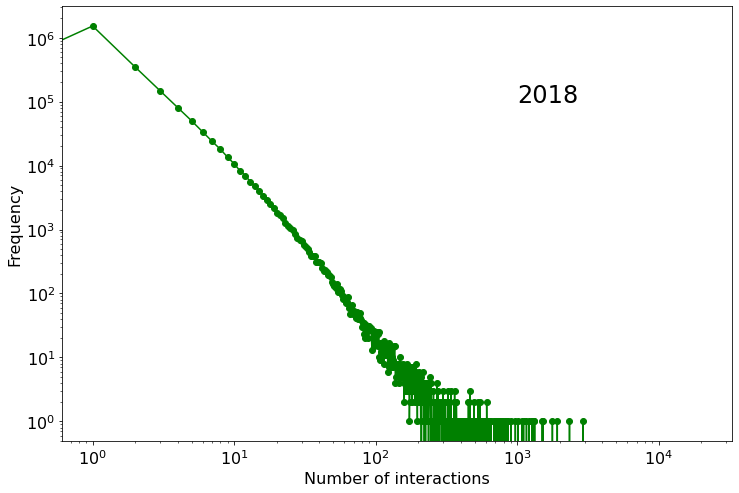

In [ ]:
# plot frequency of interaction between Binance and other nodes
# repeat for each year

degree_freq = nx.degree_histogram(G17)
degree_freq = degree_freq[:20000]

plt.figure(figsize=(12, 8)) 
plt.rcParams['font.size'] = '16'
plt.loglog(range(0, 20000), degree_freq, 'go-') 
plt.xlabel('Number of interactions')
plt.ylabel('Frequency')
plt.text(1000,100000,'2017',fontsize=24)

plt.savefig('binance_deg_dist_2017.png')

# CDF of transactions values

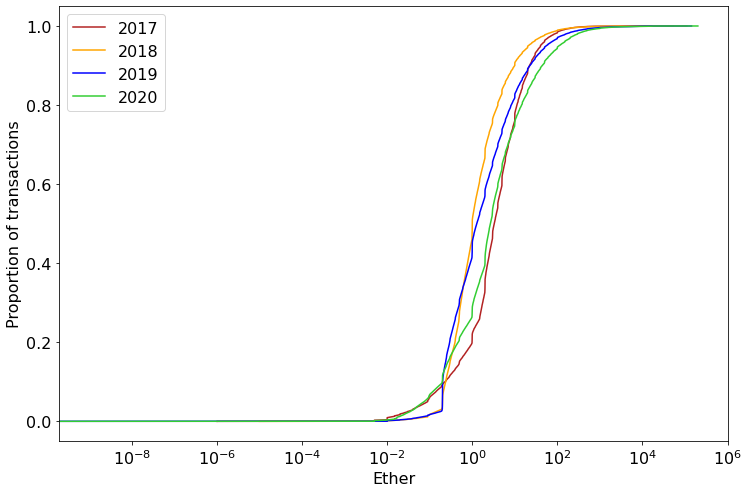

In [ ]:
val_2017 = pd.to_numeric(df_2017['value'])
x1 = np.sort(val_2017)
y1 = np.arange(len(val_2017)) / float(len(val_2017)) 

val_2018 = pd.to_numeric(df_2018['value'])
x2 = np.sort(val_2018)
y2 = np.arange(len(val_2018)) / float(len(val_2018)) 

val_2019 = pd.to_numeric(df_2019['value'])
x3 = np.sort(val_2019)
y3 = np.arange(len(val_2019)) / float(len(val_2019)) 

val_2020 = pd.to_numeric(df_2020['value'])
x4 = np.sort(val_2020)
y4 = np.arange(len(val_2020)) / float(len(val_2020)) 

plt.figure(figsize=(12, 8)) 
plt.rcParams['font.size'] = '16'
plt.xscale("log")
plt.plot(x1, y1, color="firebrick", label="2017") 
plt.plot(x2, y2, color="orange", label="2018") 
plt.plot(x3, y3, color="blue", label="2019") 
plt.plot(x4, y4, color="limegreen", label="2020")  
plt.xlabel('Ether')
plt.ylabel('Proportion of transactions')
plt.legend() 

plt.savefig('txplot_binance_all.png')

# Lifetime and trade frequency of accounts

In [ ]:
# get lifetime of trade (time of last transaction - time of first transaction)
lt_total = client.query('''
SELECT from_address, to_address, abs(TIMESTAMP_DIFF(max(block_timestamp),min(block_timestamp),MINUTE)) as lifetime
FROM `ethereum-<>.transactions.transactions_binance`
group by from_address, to_address;''').to_dataframe()

In [ ]:
# get average frequency of trade (lifetime / number of transactions)
freq_total = client.query('''
SELECT from_address, to_address, abs(TIMESTAMP_DIFF(max(block_timestamp),min(block_timestamp),MINUTE))/(count(value)-1) as freq
FROM `ethereum-<>.transactions.transactions_binance`
group by from_address, to_address
having count(value)>1;''').to_dataframe()

In [ ]:
# proportion of rows with 0 lifetime (only one transaction or no time diff between transactions)
zero_proportion = len(lt_total.loc[lt_total['lifetime'] == 0]) / len(lt_total)
print(zero_proportion)

# proportion of rows with lifetime < 1 day 
one_day_proportion = len(lt_total.loc[lt_total['lifetime'] < 1440]) / len(lt_total)
print(one_day_proportion)

# count of rows with lifetime 0 and incoming transactions from Binance
tmp = lt_total.loc[lt_total['lifetime'] == 0]
print(len(tmp.loc[tmp['from_address']=='0x3f5ce5fbfe3e9af3971dd833d26ba9b5c936f0be']))

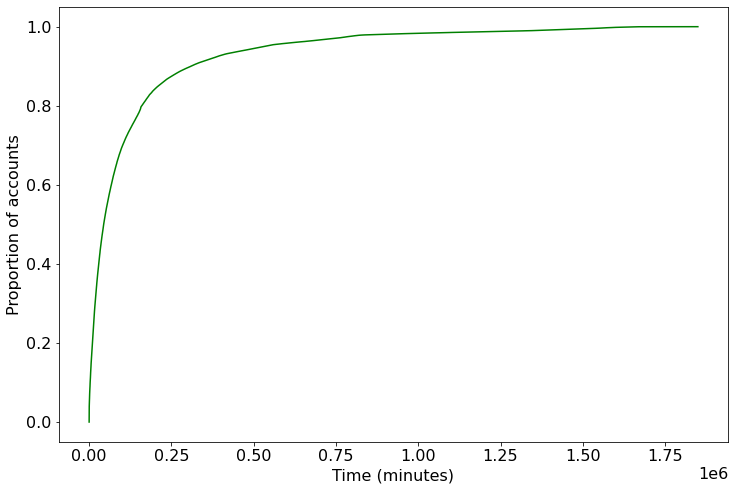

In [ ]:
# plot CDF of lifetime and average frequency values
# exclude 0 lifetime for better visualisation

tmp = lt_total.loc[lt_total['lifetime'] != 0]
lt = pd.to_numeric(tmp['lifetime'])
x_lt = np.sort(lifetime)
y_lt = np.arange(len(tmp)) / float(len(tmp)) 

freq = pd.to_numeric(freq_total['freq'])
x_freq = np.sort(freq)
y_freq = np.arange(len(freq_total)) / float(len(fre_total)) 

plt.figure(figsize=(12, 8)) 
plt.rcParams['font.size'] = '16'
plt.plot(x_lt, y_lt, color="green")  
plt.plot(x_freq, y_freq, color="blue")  
plt.xlabel('Time (minutes)')
plt.ylabel('Proportion of accounts')

plt.savefig('lifetime_binance.png')